<a href="https://colab.research.google.com/github/queenakki/AI-ML/blob/project/image_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nengo-extras # install the nengo_extras module
%matplotlib inline
import nengo # import the module
import numpy as np

from nengo_extras.data import load_mnist, one_hot_from_labels # import from nengo_extras
from nengo_extras.matplotlib import tile
from nengo_extras.vision import Gabor, Mask

rng = np.random.RandomState(9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow # Install TensorFlow if you don't have it
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = 2 * X_train - 1  # normalize to -1 to 1
X_test = 2 * X_test - 1  # normalize to -1 to 1

T_train = one_hot_from_labels(y_train, classes=10)

for i in range(5):
    print("%d -> %s" % (y_train[i], T_train[i]))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
# --- set up network parameters
n_vis = X_train.shape[1] * X_train.shape[2] # calculate the number of pixels
n_out = T_train.shape[1]

# number of hidden units
# More means better performance but longer training time.
n_hid = 1000

# Flatten the images in X_train
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

ens_params = dict(
    eval_points=X_train_flattened, # Use the flattened array
    neuron_type=nengo.LIFRate(),
    intercepts=nengo.dists.Choice([0.1]),
    max_rates=nengo.dists.Choice([100]),
     )

solver = nengo.solvers.LstsqL2(reg=0.01)

with nengo.Network(seed=3) as model:
     a = nengo.Ensemble(n_hid, n_vis, **ens_params)
     v = nengo.Node(size_in=n_out)
     conn = nengo.Connection(
     a, v, synapse=None, eval_points=X_train_flattened, function=T_train, solver=solver # Use the flattened array
      )


def get_outs(simulator, images):
# encode the images to get the ensemble activations
    _, acts = nengo.utils.ensemble.tuning_curves(a, simulator, inputs=images)

# decode the ensemble activities using the connection's decoders
    return np.dot(acts, simulator.data[conn].weights.T)


def get_error(simulator, images, labels):
 # the classification for each example is index of
 # the output dimension with the highest value
    return np.argmax(get_outs(simulator, images), axis=1) != labels


def print_error(simulator):
    train_error = 100 * get_error(simulator, X_train_flattened, y_train).mean() # Use the flattened array
    test_error = 100 * get_error(simulator, X_test.reshape(X_test.shape[0], -1) , y_test).mean() # Flatten X_test
    print("Train/test error: %0.2f%%, %0.2f%%" % (train_error, test_error))

ERROR:nengo.cache:Decoder cache index corrupted. Reinitializing cache.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/nengo/cache.py", line 467, in __enter__
    self._load_index_file()
  File "/usr/local/lib/python3.10/dist-packages/nengo/cache.py", line 389, in _load_index_file
    with self.index_path.open("rb") as f:
  File "/usr/lib/python3.10/pathlib.py", line 1119, in open
    return self._accessor.open(self, mode, buffering, encoding, errors,
FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/nengo/decoders/index'


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Train/test error: 31.87%, 32.70%


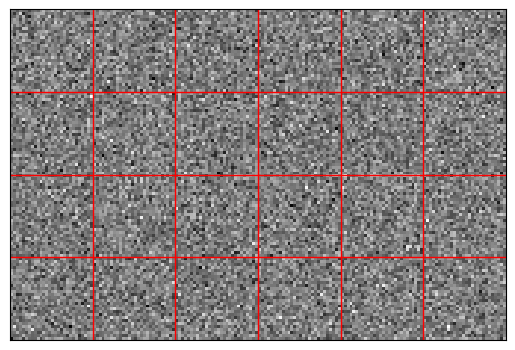

In [ ]:
encoders = rng.normal(size=(n_hid, 28 * 28))
a.encoders = encoders

tile(encoders.reshape((-1, 28, 28)), rows=4, cols=6, grid=True)

with nengo.Simulator(model) as sim:
    print_error(sim)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Train/test error: 30.09%, 31.35%


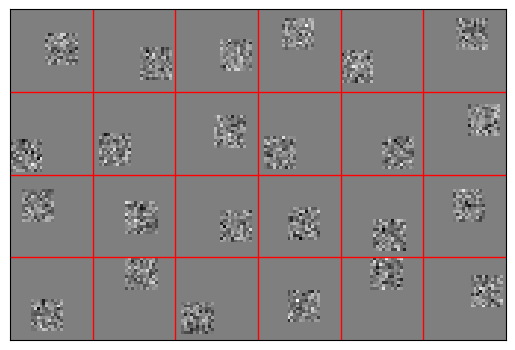

In [ ]:
encoders = rng.normal(size=(n_hid, 11, 11))
encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
a.encoders = encoders

tile(encoders.reshape((-1, 28, 28)), rows=4, cols=6, grid=True)

with nengo.Simulator(model) as sim:
    print_error(sim)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Train/test error: 27.44%, 28.57%


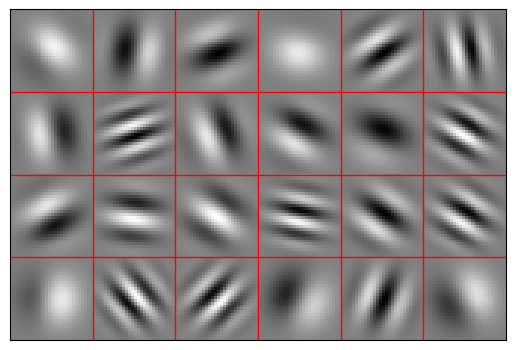

In [ ]:
encoders = Gabor().generate(n_hid, (28, 28), rng=rng).reshape((n_hid, -1))
a.encoders = encoders

tile(encoders.reshape((-1, 28, 28)), rows=4, cols=6, grid=True)

with nengo.Simulator(model) as sim:
    print_error(sim)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Train/test error: 17.24%, 17.92%


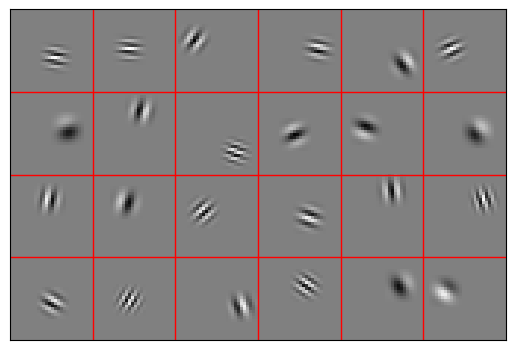

In [ ]:
encoders = Gabor().generate(n_hid, (11, 11), rng=rng)
encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
a.encoders = encoders

tile(encoders.reshape((-1, 28, 28)), rows=4, cols=6, grid=True)

with nengo.Simulator(model) as sim:
    print_error(sim)